C:\Anaconda\envs\yolov7_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Anaconda\envs\yolov7_env\lib\site-packages\torch\cuda\memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


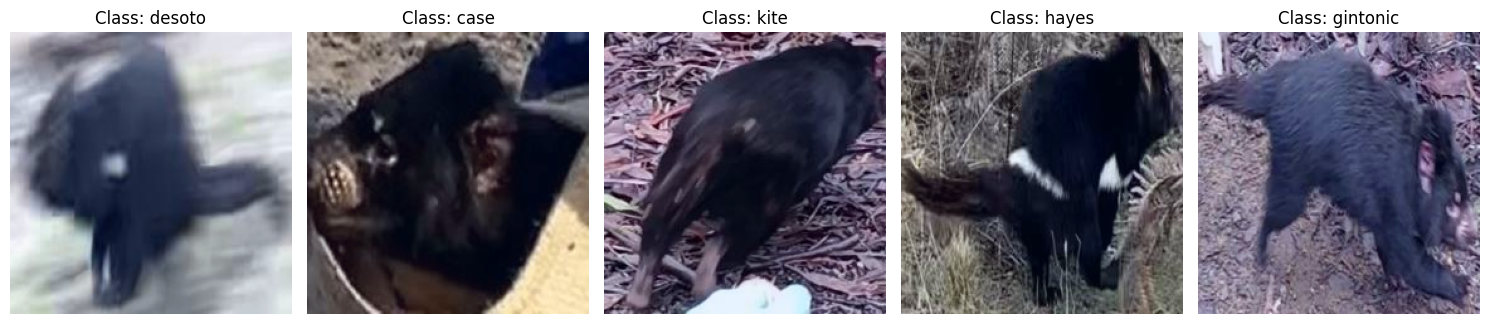

In [1]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import gc
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define dataset path
DATASET_PATH = r"D:\Master's Research\unified_dataset\final_split_safe"

torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()
gc.collect()                  # Force garbage collection
torch.cuda.empty_cache()      # Clear cached memory
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# cumulative attention map
def compute_attention_rollout(attentions, discard_ratio=0.0):
    """
    Compute cumulative attention rollout.
    """
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    for attn in attentions:
        attn_heads_fused = attn.mean(1)  # Average over heads
        flat = attn_heads_fused
        flat = flat / flat.sum(dim=-1, keepdim=True)
        result = torch.matmul(flat, result)

    mask = result[0, 0, 1:]  # Exclude CLS token
    mask = mask.reshape(14, 14).cpu().detach().numpy()  # Assuming 14x14 patches
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    return mask

def visualize_attention(image_path, model, transform, save_path=None):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model.backbone(img_tensor)

    # Compute rollout
    attn_mask = compute_attention_rollout(model.backbone.attentions)

    # Resize heatmap
    heatmap = cv2.resize(attn_mask, img.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay
    img_np = np.array(img)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("ViT+CATLA Attention Map")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# === Load Metadata to Extract Sex and Age ===
def load_metadata_dicts(excel_path):
    xls = pd.ExcelFile(excel_path)
    df1 = xls.parse('Fentonbury Apr_May 2024')
    df2 = xls.parse('Bronte')

    df1 = df1[['Individual_name', 'Sex', 'Age_years']]
    df2 = df2[['Individual_name', 'Sex', 'Age_years']]
    df = pd.concat([df1, df2], ignore_index=True)

    df['Individual_name'] = df['Individual_name'].astype(str).str.strip().str.lower()
    df['Sex'] = df['Sex'].astype(str).str.strip().str.lower()

    def map_age(age):
        if pd.isna(age):
            return None
        elif age >= 4:
            return 'more_than_4'
        else:
            return str(int(age))

    df['Age_Group'] = df['Age_years'].apply(map_age)
    df = df.dropna(subset=['Sex', 'Age_Group'])

    sex_map = dict(zip(df['Individual_name'], df['Sex']))
    age_map = dict(zip(df['Individual_name'], df['Age_Group']))
    return sex_map, age_map

# Load metadata and encoders
metadata_excel_path = r"C:\Users\Jaylen LI\Downloads\1st_share\1st_share\All sites metadata for AI 2024_working copy.xlsx"
individual_to_sex, individual_to_age = load_metadata_dicts(metadata_excel_path)

sex_label_encoder = LabelEncoder()
sex_label_encoder.fit(list(set(individual_to_sex.values())))

age_label_encoder = LabelEncoder()
age_label_encoder.fit(list(set(individual_to_age.values())))


# Define Dataset Class
class WildlifeDataset(Dataset):
    def __init__(self, root_dir, label_type="individual", class_names=None,
                 sex_map=None, age_map=None, sex_encoder=None, age_encoder=None):
        self.label_type = label_type
        self.sex_map = sex_map
        self.age_map = age_map
        self.sex_encoder = sex_encoder
        self.age_encoder = age_encoder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.image_paths = []
        self.labels = []
        self.classes = class_names if class_names else sorted(os.listdir(root_dir))

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                full_path = os.path.join(class_dir, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(full_path)

                    if self.label_type == "individual":
                        label = self.classes.index(class_name)
                    else:
                        raise ValueError(f"Unsupported label_type: {self.label_type}")
                    
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)
        return image_tensor, label, image_path


# === Shared Setup ===
shared_class_names = sorted([
    d.lower().strip() for d in os.listdir(os.path.join(DATASET_PATH, 'fold_4/train/images'))
    if os.path.isdir(os.path.join(DATASET_PATH, 'fold_4/train/images', d))
])

num_sex_classes = len(sex_label_encoder.classes_)
num_age_classes = len(age_label_encoder.classes_)

# === Load Dataset  ===
train_dataset = WildlifeDataset(
    os.path.join(DATASET_PATH, 'fold_4/train/images'),
    label_type="individual",  
    class_names=shared_class_names
)


val_dataset = WildlifeDataset(
    os.path.join(DATASET_PATH, 'fold_4/val/images'),
    label_type="individual",  
    class_names=shared_class_names
)


test_dataset = WildlifeDataset(
    os.path.join(DATASET_PATH, 'test/images'),
    label_type="individual",  
    class_names=shared_class_names
)

# === Dataloaders ===
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Display Example Classes & Images
def show_example_images(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    random_indices = random.sample(range(len(dataset)), num_examples)

    for i, idx in enumerate(random_indices):
        output = dataset[idx]
        
        # Handle both two-label and three-label output cases
        if dataset.label_type == "sex_age":
            image, sex_label, age_label, img_path = output
            title = f"Sex: {sex_label}, Age: {age_label}"
        else:
            image, label, img_path = output
            title = f"Class: {dataset.classes[label]}" if dataset.classes else f"Label: {label}"
        
        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())
        
        axes[i].imshow(image)
        axes[i].set_title(title)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Run Example
show_example_images(train_dataset)


In [2]:
#Implement Cross-Attention Block (CAB)
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super().__init__()
        self.inner_patch_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.cross_patch_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        # Inner-Patch Self-Attention (IPSA)
        x_residual = x
        x = self.ln1(x)
        x, _ = self.inner_patch_attention(x, x, x)
        x = x_residual + x  # Skip connection

        # Cross-Patch Self-Attention (CPSA)
        x_residual = x
        x = self.ln2(x)
        x, _ = self.cross_patch_attention(x, x, x)
        x = x_residual + x  # Skip connection
        
        # Feedforward MLP
        x = x + self.mlp(x)
        return x


In [3]:
#Implement ViT Backbone with Cross-Attention
class ViTBackbone(nn.Module):
    def __init__(self, depth=3):
        super().__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.attentions = []

        # Register hook to capture attention maps
        def get_attention_hook(module, input, output):
            self.attentions.append(output)

        # Hook into all attention layers
        for blk in self.vit.blocks:
            blk.attn.register_forward_hook(get_attention_hook)

        self.cross_attention = nn.ModuleList([CrossAttentionBlock() for _ in range(depth)])

    def forward(self, x):
        self.attentions = []  # Reset attention storage
        x = self.vit.forward_features(x)
        for cab in self.cross_attention:
            x = cab(x)
        return x


In [4]:
# Locally Aware Network (LAN)
class LocallyAwareNetwork(nn.Module):
    def __init__(self, embed_dim=768, num_layers=7, lambda_weight=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.lambda_weight = lambda_weight
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        global_token = x[:, 0]               # CLS token
        local_tokens = x[:, 1:]              # Patch tokens
        fused = (local_tokens + self.lambda_weight * global_token.unsqueeze(1)) / (1 + self.lambda_weight)
        fused = fused.view(-1, self.num_layers, 28, 768)  # Reshape if needed
        fused = self.fc(fused)
        pooled = fused.mean(dim=2).mean(dim=1)
        return pooled


In [5]:
class CATLATransformer(nn.Module):
    def __init__(self, num_individuals):
        super().__init__()
        self.backbone = ViTBackbone(depth=3)
        self.lan = LocallyAwareNetwork()
        self.id_head = nn.Linear(768, num_individuals)

    def forward(self, x):
        x = self.backbone(x)
        x = self.lan(x)
        id_logits = self.id_head(x)
        return id_logits



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CATLATransformer(num_individuals=len(shared_class_names)).to(device)

# Use separate losses for each task
loss_fn_id = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)


In [7]:
# Load partial checkpoint (ignore classifier mismatch)
checkpoint = torch.load("final_CATLA_id.pth", map_location=device)

# Get current model parameters
model_dict = model.state_dict()

# Filter out mismatched keys (like classifier weights/bias)
filtered_dict = {k: v for k, v in checkpoint.items()
                 if k in model_dict and model_dict[k].shape == v.shape}

# Update model with compatible weights only
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)

print(f" Loaded {len(filtered_dict)} compatible parameters from checkpoint.")


 Loaded 198 compatible parameters from checkpoint.


In [8]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Loss, Optimizer, Scheduler ===
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# === Early Stopping Setup ===
best_val_acc = 0
patience = 5
counter = 0
early_stop = False
best_model_path = "earlystop_best_CATLA_id.pth"

# === Logging ===
num_epochs = 30
train_losses, val_losses = [], []
train_accs_id, val_accs_id = [], []

true_train_id, pred_train_id = [], []
true_val_id, pred_val_id = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_id = 0
    total = 0

    for images, id_labels, paths in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        images = images.to(device)
        id_labels = id_labels.to(device).long()

        optimizer.zero_grad()
        id_logits = model(images)  # model returns only id_logits now
        loss = ce_loss_fn(id_logits, id_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += images.size(0)
        correct_id += (id_logits.argmax(1) == id_labels).sum().item()

        true_train_id.extend(id_labels.cpu().numpy())
        pred_train_id.extend(id_logits.argmax(1).cpu().numpy())

    train_losses.append(train_loss / len(train_loader))
    train_accs_id.append(correct_id / total)

    # === Validation ===
    model.eval()
    val_loss = 0
    correct_id = 0
    total = 0

    with torch.no_grad():
        for images, id_labels, paths in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
            images = images.to(device)
            id_labels = id_labels.to(device).long()

            id_logits = model(images)
            loss = ce_loss_fn(id_logits, id_labels)
            val_loss += loss.item()

            total += images.size(0)
            correct_id += (id_logits.argmax(1) == id_labels).sum().item()

            true_val_id.extend(id_labels.cpu().numpy())
            pred_val_id.extend(id_logits.argmax(1).cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accs_id.append(correct_id / total)

    scheduler.step()

    print(f" Epoch {epoch+1}: "
          f"Train ID Acc: {train_accs_id[-1]:.4f}, "
          f"Val ID Acc: {val_accs_id[-1]:.4f}")

    # === Early Stopping Check ===
    if val_accs_id[-1] > best_val_acc:
        best_val_acc = val_accs_id[-1]
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(" Best model updated.")
    else:
        counter += 1
        print(f" No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print(" Early stopping triggered.")
            early_stop = True
            break

# === Load Best Model ===
if early_stop:
    model.load_state_dict(torch.load(best_model_path))
    print(" Loaded best model saved via early stopping.")
else:
    torch.save(model.state_dict(), "final_CATLA_id.pth")
    print(" Saved final model.")


Epoch 1 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  8.11it/s]


 Epoch 1: Train ID Acc: 0.0331, Val ID Acc: 0.0610
 Best model updated.


Epoch 2 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.95it/s]


 Epoch 2: Train ID Acc: 0.0845, Val ID Acc: 0.0915
 Best model updated.


Epoch 3 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.88it/s]


 Epoch 3: Train ID Acc: 0.2605, Val ID Acc: 0.2622
 Best model updated.


Epoch 4 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.86it/s]


 Epoch 4: Train ID Acc: 0.4878, Val ID Acc: 0.4146
 Best model updated.


Epoch 5 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.78it/s]


 Epoch 5: Train ID Acc: 0.6394, Val ID Acc: 0.6189
 Best model updated.


Epoch 6 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.84it/s]


 Epoch 6: Train ID Acc: 0.8005, Val ID Acc: 0.6159
 No improvement. Patience: 1/5


Epoch 7 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.85it/s]


 Epoch 7: Train ID Acc: 0.8406, Val ID Acc: 0.7165
 Best model updated.


Epoch 8 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.81it/s]


 Epoch 8: Train ID Acc: 0.8789, Val ID Acc: 0.7195
 Best model updated.


Epoch 9 - Val: 100%|███████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.91it/s]


 Epoch 9: Train ID Acc: 0.9364, Val ID Acc: 0.7317
 Best model updated.


Epoch 10 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.86it/s]


 Epoch 10: Train ID Acc: 0.9408, Val ID Acc: 0.6402
 No improvement. Patience: 1/5


Epoch 11 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.87it/s]


 Epoch 11: Train ID Acc: 0.9634, Val ID Acc: 0.8049
 Best model updated.


Epoch 12 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.88it/s]


 Epoch 12: Train ID Acc: 0.9974, Val ID Acc: 0.8232
 Best model updated.


Epoch 13 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.81it/s]


 Epoch 13: Train ID Acc: 1.0000, Val ID Acc: 0.8323
 Best model updated.


Epoch 14 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.78it/s]


 Epoch 14: Train ID Acc: 1.0000, Val ID Acc: 0.8384
 Best model updated.


Epoch 15 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.68it/s]


 Epoch 15: Train ID Acc: 1.0000, Val ID Acc: 0.8415
 Best model updated.


Epoch 16 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.81it/s]


 Epoch 16: Train ID Acc: 1.0000, Val ID Acc: 0.8537
 Best model updated.


Epoch 17 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.83it/s]


 Epoch 17: Train ID Acc: 1.0000, Val ID Acc: 0.8537
 No improvement. Patience: 1/5


Epoch 18 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.80it/s]


 Epoch 18: Train ID Acc: 1.0000, Val ID Acc: 0.8567
 Best model updated.


Epoch 19 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.86it/s]


 Epoch 19: Train ID Acc: 1.0000, Val ID Acc: 0.8567
 No improvement. Patience: 1/5


Epoch 20 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.80it/s]


 Epoch 20: Train ID Acc: 1.0000, Val ID Acc: 0.8567
 No improvement. Patience: 2/5


Epoch 21 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.85it/s]


 Epoch 21: Train ID Acc: 1.0000, Val ID Acc: 0.8567
 No improvement. Patience: 3/5


Epoch 22 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.83it/s]


 Epoch 22: Train ID Acc: 1.0000, Val ID Acc: 0.8567
 No improvement. Patience: 4/5


Epoch 23 - Val: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.81it/s]

 Epoch 23: Train ID Acc: 1.0000, Val ID Acc: 0.8567
 No improvement. Patience: 5/5
 Early stopping triggered.
 Loaded best model saved via early stopping.


In [9]:
from sklearn.metrics import classification_report

# === INDIVIDUAL ID REPORTS ===
print("\n Final INDIVIDUAL ID Classification Report (Train):")
print(classification_report(true_train_id, pred_train_id, target_names=shared_class_names))

print("\n Final INDIVIDUAL ID Classification Report (Validation):")
print(classification_report(true_val_id, pred_val_id, target_names=shared_class_names))




 Final INDIVIDUAL ID Classification Report (Train):
                   precision    recall  f1-score   support

            caipi       0.81      0.75      0.78       644
             case       0.84      0.87      0.86       644
             chev       0.82      0.79      0.81       644
            colet       0.78      0.82      0.80       644
            cosmo       0.86      0.85      0.85       644
         daiquiri       0.79      0.85      0.82       644
      darrenhayes       0.79      0.75      0.77       644
             dart       0.77      0.80      0.78       644
           desoto       0.83      0.90      0.86       644
        diamond t       0.83      0.80      0.81       644
             dina       0.83      0.86      0.84       644
           fageol       0.85      0.84      0.85       644
            fargo       0.87      0.89      0.88       644
             fiat       0.80      0.80      0.80       644
          freeman       0.94      0.81      0.87       644
  

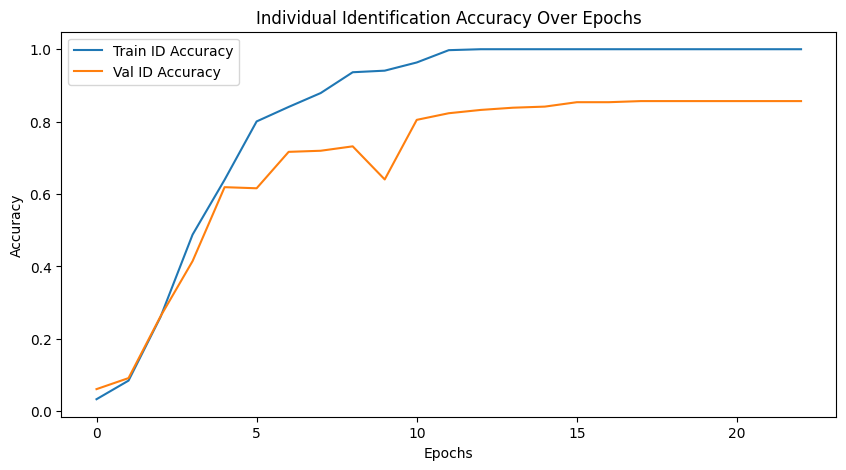

In [10]:
#Step 6.3: Plot Training & Validation Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accs_id, label="Train ID Accuracy")
plt.plot(val_accs_id, label="Val ID Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Individual Identification Accuracy Over Epochs")
plt.show()



In [11]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report, average_precision_score
from sklearn.preprocessing import label_binarize

# === Ensure device is set ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Final Model Weights ===
checkpoint = torch.load("final_CATLA_id.pth", map_location=device)
model_dict = model.state_dict()
filtered_dict = {k: v for k, v in checkpoint.items() if k in model_dict and model_dict[k].shape == v.shape}
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
print(f" Re-loaded {len(filtered_dict)} compatible weights for testing.")
model.eval()

# === Initialize Storage ===
true_test_ids, pred_test_ids = [], []
rank1_count, rank5_count = 0, 0


# === Inference Loop ===
with torch.no_grad():
    for images, id_labels, paths in test_loader:
        images = images.to(device)
        id_labels = id_labels.to(device).long()

        # Forward pass (ID only)
        id_logits = model(images)

        # Top-K accuracy
        probs = torch.softmax(id_logits, dim=-1)
        top5_preds = torch.topk(probs, 5, dim=-1).indices
        rank1_count += (top5_preds[:, 0] == id_labels).sum().item()
        rank5_count += (top5_preds == id_labels.view(-1, 1)).sum().item()
        pred_ids = probs.argmax(dim=1)

        true_test_ids.extend(id_labels.cpu().numpy())
        pred_test_ids.extend(pred_ids.cpu().numpy())

# === Evaluation Metrics ===
num_classes = len(shared_class_names)
true_test_ids_onehot = label_binarize(true_test_ids, classes=np.arange(num_classes))
pred_test_ids_onehot = label_binarize(pred_test_ids, classes=np.arange(num_classes))

acc_id = accuracy_score(true_test_ids, pred_test_ids)
f1_id = f1_score(true_test_ids, pred_test_ids, average="weighted")
mAP_id = average_precision_score(true_test_ids_onehot, pred_test_ids_onehot, average="macro")
rank1 = rank1_count / len(true_test_ids)
rank5 = rank5_count / len(true_test_ids)

print("\n Individual Identification Metrics (Test):")
print(f"Accuracy: {acc_id:.4f} | F1: {f1_id:.4f} | mAP: {mAP_id:.4f}")
print(f"Rank-1 Accuracy: {rank1:.4f} | Rank-5 Accuracy: {rank5:.4f}")

print("\n Classification Report (Individual ID):")
print(classification_report(true_test_ids, pred_test_ids, target_names=shared_class_names))


 Re-loaded 202 compatible weights for testing.

 Individual Identification Metrics (Test):
Accuracy: 0.8227 | F1: 0.8218 | mAP: 0.6942
Rank-1 Accuracy: 0.8227 | Rank-5 Accuracy: 0.9263

 Classification Report (Individual ID):
                   precision    recall  f1-score   support

            caipi       0.91      0.71      0.80        14
             case       1.00      1.00      1.00        21
             chev       0.60      0.86      0.71         7
            colet       0.88      0.70      0.78        10
            cosmo       0.80      0.92      0.86        13
         daiquiri       0.86      1.00      0.92         6
      darrenhayes       0.88      0.70      0.78        30
             dart       0.65      0.81      0.72        16
           desoto       1.00      1.00      1.00         3
        diamond t       1.00      0.89      0.94        35
             dina       0.88      1.00      0.93         7
           fageol       0.90      1.00      0.95        18
      

In [12]:
import pandas as pd
from sklearn.metrics import classification_report

def save_classification_report(true_labels, pred_labels, target_names, file_path):
    """Save classification report to CSV"""
    report_dict = classification_report(true_labels, pred_labels, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df.to_csv(file_path)
    print(f" Classification report saved to: {file_path}")


In [13]:
# === Export Reports ===
output_dir = r"D:\Master's Research\ViT+CATLA Transformer\results_id"

# === Individual ID Reports ===
save_classification_report(true_train_id, pred_train_id, shared_class_names,
    os.path.join(output_dir, "fold_report_train_id.csv"))

save_classification_report(true_val_id, pred_val_id, shared_class_names,
    os.path.join(output_dir, "fold_report_val_id.csv"))

save_classification_report(true_test_ids, pred_test_ids, shared_class_names,
    os.path.join(output_dir, "fold_report_test_id.csv"))



 Classification report saved to: D:\Master's Research\ViT+CATLA Transformer\results_id\fold_report_train_id.csv
 Classification report saved to: D:\Master's Research\ViT+CATLA Transformer\results_id\fold_report_val_id.csv
 Classification report saved to: D:\Master's Research\ViT+CATLA Transformer\results_id\fold_report_test_id.csv


 Saved: D:\Master's Research\ViT+CATLA Transformer\results_id\fold_cm_test_id.csv


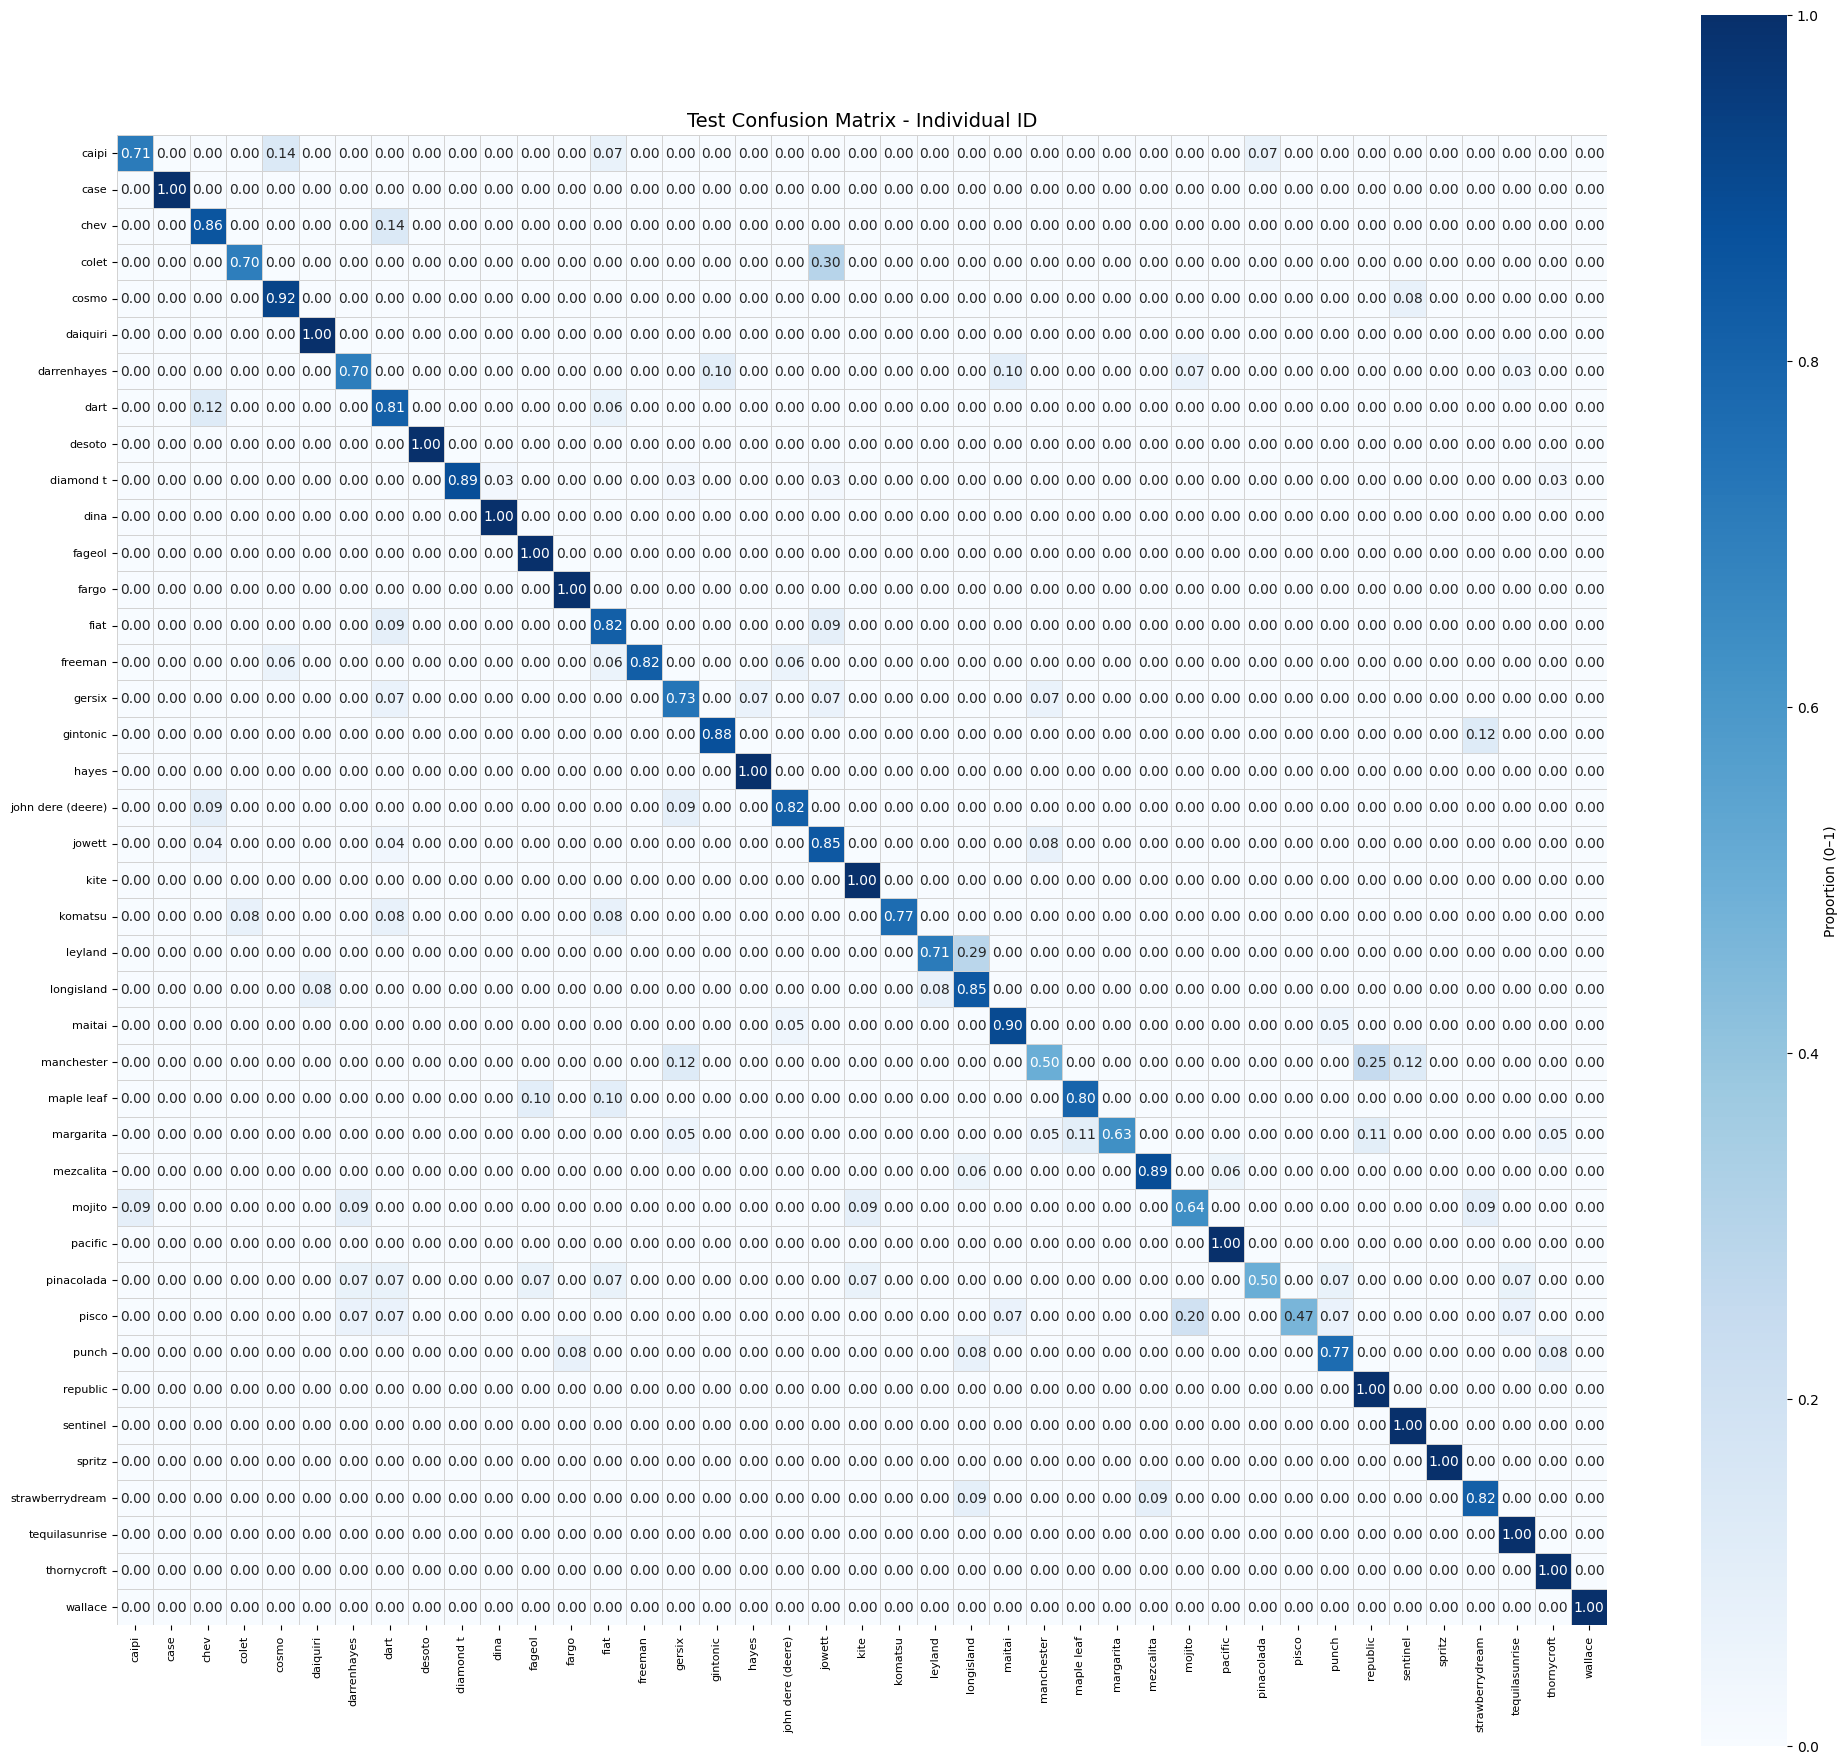

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, class_names,
                          dataset_name="Confusion Matrix", file_path=None):
    labels = list(range(len(class_names)))
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    # Normalize row-wise
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    # === Save to CSV ===
    if file_path:
        df_cm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)
        df_cm.to_csv(file_path)
        print(f" Saved: {file_path}")

    # === Plot ===
    plt.figure(figsize=(20, 18))  # larger canvas
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={"label": "Proportion (0–1)"}
    )
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(dataset_name, fontsize=14)
    plt.tight_layout()


    
output_dir = r"D:\Master's Research\ViT+CATLA Transformer\results_id"

# === Individual ID ===
plot_confusion_matrix(
    true_test_ids,
    pred_test_ids,
    shared_class_names,
    dataset_name="Test Confusion Matrix - Individual ID",
    file_path=os.path.join(output_dir, "fold_cm_test_id.csv")
)



In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_multiclass_roc(true_labels, pred_probs, class_names, title="ROC Curve", save_path=None, auc_csv_path=None):
    n_classes = pred_probs.shape[1]
    y_test_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        if np.sum(y_test_bin[:, i]) == 0:
            continue  # skip class if no samples
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        mean_fpr = np.linspace(0, 1, 100)
        tpr_interp = interp(mean_fpr, fpr[i], tpr[i])
        plt.plot(mean_fpr, tpr_interp, lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), pred_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle=':', color='black',
             label=f'Micro-average (AUC = {roc_auc_micro:.2f})', lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small')
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f" ROC saved: {save_path}")
    else:
        plt.show()

    if auc_csv_path:
        auc_df = pd.DataFrame.from_dict(roc_auc, orient='index', columns=["AUC"])
        auc_df.index = [class_names[i] for i in auc_df.index]
        auc_df.to_csv(auc_csv_path)
        print(f" AUC scores saved to: {auc_csv_path}")


In [16]:
# Inference across test set (ID only)
true_test_id, pred_test_id = [], []
id_logits_test = []

model.eval()
with torch.no_grad():
    for images, id_labels, paths in tqdm(test_loader, desc="Test Inference"):
        images = images.to(device)
        id_labels = id_labels.to(device)

        id_logits = model(images)

        # Collect true & predicted IDs
        true_test_id.extend(id_labels.cpu().numpy())
        pred_test_id.extend(id_logits.argmax(1).cpu().numpy())
        id_logits_test.append(id_logits.cpu())

# Stack logits if needed later (e.g., ROC)
id_logits_test = torch.cat(id_logits_test, dim=0)


Test Inference: 100%|██████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.38it/s]


C:\Users\Jaylen LI\AppData\Local\Temp\ipykernel_32228\1431035574.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_interp = interp(mean_fpr, fpr[i], tpr[i])
C:\Users\Jaylen LI\AppData\Local\Temp\ipykernel_32228\1431035574.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_interp = interp(mean_fpr, fpr[i], tpr[i])
C:\Users\Jaylen LI\AppData\Local\Temp\ipykernel_32228\1431035574.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_interp = interp(mean_fpr, fpr[i], tpr[i])
C:\Users\Jaylen LI\AppData\Local\Temp\ipykernel_32228\1431035574.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr_interp = interp(mean_fpr, fpr[i], tpr[i])
C:\Users\Jaylen LI\AppData\Local\Temp\ipykernel_32228\1431035574.py:25: DeprecationWarni

 ROC saved: D:\Master's Research\ViT+CATLA Transformer\results_id\roc_test_id.png
 AUC scores saved to: D:\Master's Research\ViT+CATLA Transformer\results_id\roc_test_id_auc.csv


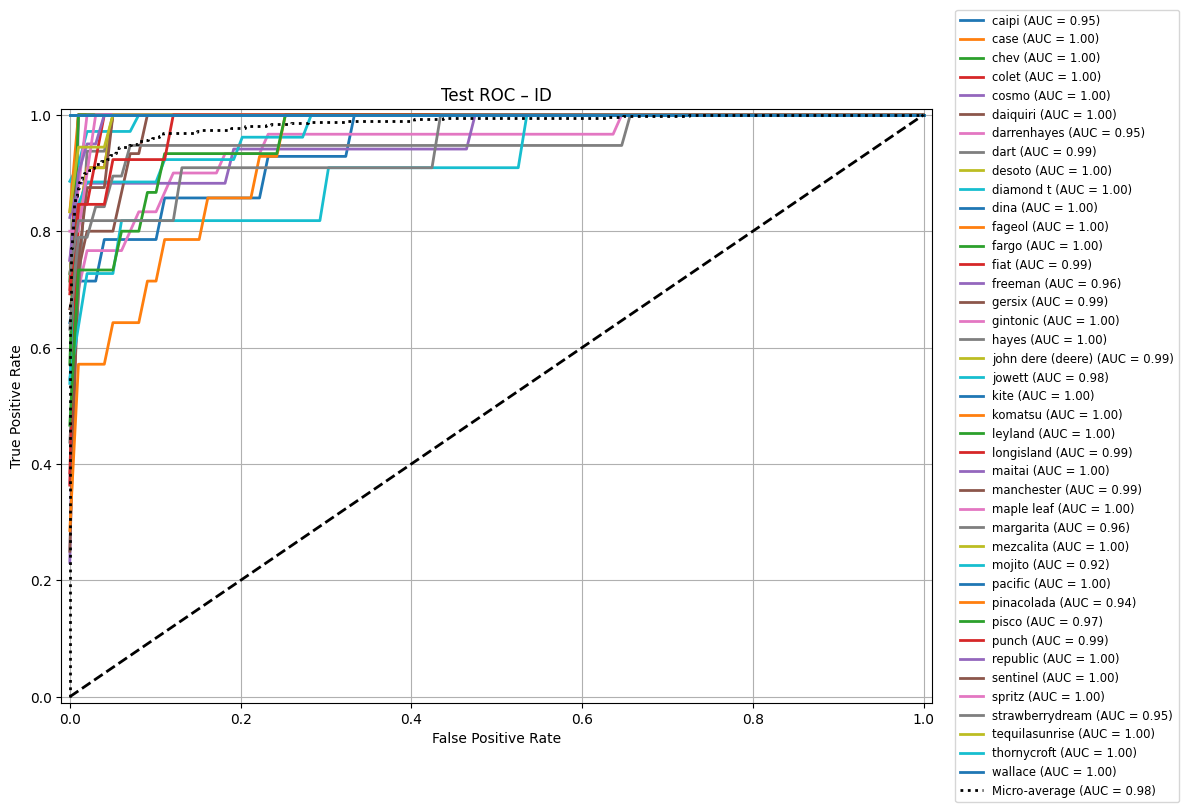

In [17]:
from torch.nn.functional import softmax

# Multiclass → Softmax for ID predictions
id_probs_test = softmax(id_logits_test, dim=1).cpu().numpy()

# Plot ROC for ID
plot_multiclass_roc(
    
    true_test_id,
    id_probs_test,
    test_dataset.classes,
    title="Test ROC – ID",
    save_path=r"D:\Master's Research\ViT+CATLA Transformer\results_id\roc_test_id.png",
    auc_csv_path=r"D:\Master's Research\ViT+CATLA Transformer\results_id\roc_test_id_auc.csv"
)


In [18]:
'''
import os
from PIL import Image
import pandas as pd

# Root path to analyze
dataset_root = r"D:\Master's Research\unified_dataset\final_split_safe"

# Results
summary = []
resolution_data = []

# Walk through all fold_X/train|val/images and test/images
for root, dirs, files in os.walk(dataset_root):
    if "images" not in root:
        continue

    for class_dir in dirs:
        class_path = os.path.join(root, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Extract split and set
        path_parts = os.path.normpath(class_path).split(os.sep)
        if 'test' in path_parts:
            split = 'test'
            set_type = 'test'
        else:
            split = path_parts[-4]  
            set_type = path_parts[-3]  # train or val

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    resolution_data.append({
                        "Split": split,
                        "Set": set_type,
                        "Class": class_dir,
                        "Image": img_file,
                        "Width": width,
                        "Height": height
                    })
            except Exception as e:
                print(f"❌ Error reading {img_path}: {e}")
                continue

        summary.append({
            "Split": split,
            "Set": set_type,
            "Class": class_dir,
            "Num_Images": len(image_files)
        })

# Convert to DataFrames
df_summary = pd.DataFrame(summary)
df_res = pd.DataFrame(resolution_data)

# Pivot for image count table
pivot_summary = df_summary.pivot_table(index=['Split', 'Set'], columns='Class', values='Num_Images', aggfunc='sum').fillna(0).astype(int)

# Resolution stats
res_stats = df_res.groupby(['Split', 'Set', 'Class'])[['Width', 'Height']].agg(['min', 'max', 'mean']).round(1)

# Save to Excel
output_file = os.path.join(dataset_root, "dataset_analysis.xlsx")
with pd.ExcelWriter(output_file) as writer:
    df_summary.to_excel(writer, sheet_name="Image_Counts", index=False)
    df_res.to_excel(writer, sheet_name="Resolutions", index=False)
    res_stats.to_excel(writer, sheet_name="Resolution_Stats")

print(f" Dataset analysis saved to: {output_file}")
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 114-115: truncated \uXXXX escape (2603813612.py, line 1)

#### 